# EDA

In [154]:
import pandas as pd
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import geoplot.crs as gcrs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl

def default_plot(ax, spines): 
    
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

In [111]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [112]:
# open data
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)
# transform to datetime
crime['date'] = pd.to_datetime(crime['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [113]:
crime.description.value_counts()[:20]

PETIT LARCENY                     984505
HARRASSMENT 2                     733522
ASSAULT 3 & RELATED OFFENSES      623550
CRIMINAL MISCHIEF & RELATED OF    594719
GRAND LARCENY                     505759
DANGEROUS DRUGS                   369783
OFF. AGNST PUB ORD SENSBLTY &     310818
FELONY ASSAULT                    227046
ROBBERY                           216401
BURGLARY                          203927
MISCELLANEOUS PENAL LAW           148146
DANGEROUS WEAPONS                 138989
OFFENSES AGAINST PUBLIC ADMINI    118389
GRAND LARCENY OF MOTOR VEHICLE    103253
INTOXICATED & IMPAIRED DRIVING     82341
VEHICLE AND TRAFFIC LAWS           72680
CRIMINAL TRESPASS                  69732
SEX CRIMES                         66807
THEFT-FRAUD                        61160
FORGERY                            58875
Name: description, dtype: int64

In [114]:
crime.premises.value_counts()[:20]

STREET                          1913118
RESIDENCE - APT. HOUSE          1250281
RESIDENCE-HOUSE                  566636
RESIDENCE - PUBLIC HOUSING       452722
OTHER                            160590
COMMERCIAL BUILDING              152028
TRANSIT - NYC SUBWAY             129121
CHAIN STORE                      127502
DEPARTMENT STORE                 120639
GROCERY/BODEGA                    74802
PUBLIC SCHOOL                     71084
PARK/PLAYGROUND                   71021
RESTAURANT/DINER                  69162
BAR/NIGHT CLUB                    66898
DRUG STORE                        51226
CLOTHING/BOUTIQUE                 50823
PUBLIC BUILDING                   36596
PARKING LOT/GARAGE (PUBLIC)       33483
FOOD SUPERMARKET                  32952
PARKING LOT/GARAGE (PRIVATE)      30842
Name: premises, dtype: int64

In [80]:
violent = ['FELONY ASSAULT', 'ROBBERY', 'RAPE']
propert = ['BURGLARY', 'ARSON', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']

crime_filter = ['BURGLARY', 'ROBBERY']
crime_subset = crime[crime.description.isin(crime_filter)]

In [81]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

In [90]:
def choropleth_text(basemap):
    
    basemap['coords'] = basemap['geometry'].apply(lambda x: x.representative_point().coords[:])
    basemap['coords'] = [coords[0] for coords in basemap['coords']]
    bbox_props = dict(boxstyle='round,pad=0.25', fc='white', ec='black')
    
    #base = basemap.plot(figsize=(12, 12), color='white', edgecolor='black', lw= 1, alpha=0.5)
    ax = geoplot.choropleth(basemap, hue='rates', figsize=(12, 12), lw= 1, edgecolor='k', alpha=1, cmap='plasma', projection=gcrs.AlbersEqualArea())
    
    #for idx, row in basemap.iterrows():
        #base.text(s=str(row['precinct']), x=row['coords'][0], y=row['coords'][1], bbox = bbox_props, fontsize=10)
    
    plt.savefig('figures/arimap.png', dpi=300)

In [83]:
arima = pd.read_csv('arima_results.csv', index_col=0)
rates = arima.groupby('precinct').agg(rates=('prediction','mean'))
rates.sort_values(by='rates', ascending=False, inplace=True)

In [84]:
clean_map = clean_map.merge(rates, on='precinct')
#clean_map.sort_values(by='count', ascending=False, inplace=True)
clean_map

,precinct,geometry,rates
0,102,"POLYGON ((-73.84451 40.68242, -73.84494 40.682...",73.088092
1,104,"POLYGON ((-73.85845 40.70578, -73.85828 40.705...",104.015981
2,13,"POLYGON ((-73.97157 40.72769, -73.97157 40.727...",149.806915
3,105,"POLYGON ((-73.72814 40.66551, -73.72811 40.665...",136.207613
4,110,"POLYGON ((-73.88501 40.72837, -73.88559 40.728...",124.064550
...,...,...,...
72,90,"POLYGON ((-73.95162 40.71407, -73.94937 40.714...",127.448791
73,84,"POLYGON ((-73.98084 40.68876, -73.98069 40.688...",91.830118
74,94,"POLYGON ((-73.95348 40.71407, -73.95434 40.714...",71.954773
75,9,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",108.551407


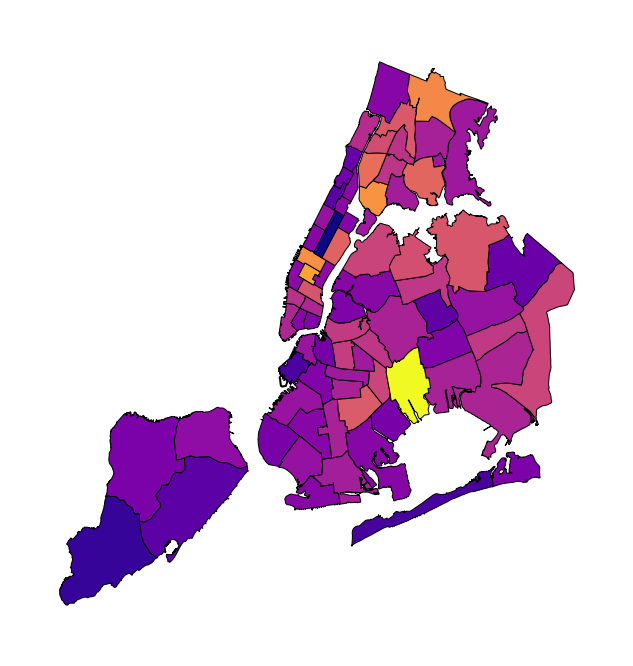

In [91]:
choropleth_text(clean_map)

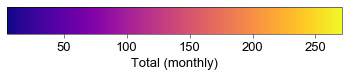

In [89]:
def make_colorbar(data, units, cmap, filename):
    
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    
    norm = mpl.colors.Normalize(vmin=min(data), vmax=max(data))

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    #cb1.set_ticks([25000, 50000, 75000, 100000, 125000, 150000, 175000])
    #cb1.set_ticklabels(['25', '50', '75', '100', '125', '150', '175'])
    cb1.set_label(units)
    plt.savefig(filename)
    
make_colorbar(clean_map['rates'], 'Total (monthly)', mpl.cm.get_cmap('plasma'), 'figures/precinct_heatmap_colorbar.png')

In [ ]:
arima

In [119]:
burg

,precinct,prediction,observed,random_prediction,date,perc,random_perc
0,75,16,23,6,2017-01-01,69.565217,26.086957
1,43,9,12,8,2017-01-01,75.000000,66.666667
2,103,5,10,5,2017-01-01,50.000000,50.000000
3,67,6,11,3,2017-01-01,54.545455,27.272727
4,47,15,20,8,2017-01-01,75.000000,40.000000
...,...,...,...,...,...,...,...
115,75,11,19,3,2018-12-01,57.894737,15.789474
116,43,3,5,1,2018-12-01,60.000000,20.000000
117,103,0,2,1,2018-12-01,0.000000,50.000000
118,67,7,6,3,2018-12-01,100.000000,50.000000


In [92]:
historical = [184652, 162908, 154809, 147069, 142093, 135475, 128682, 121009, 117956, 106730, 105115, 106669, 111147, 111335, 106722, 105453, 101716, 96658, 95883, 95606]

In [93]:
robb = pd.read_csv('robbery.csv', index_col=0)
burg = pd.read_csv('burglary.csv', index_col=0)

In [98]:
clustering = burg[burg.precinct == 75]['perc']
random = burg[burg.precinct == 75]['random_perc']

In [107]:
burglary_final = burg.groupby('date').agg('sum')
burglary_final['perc'] = burglary_final['prediction']/burglary_final['observed']*100
burglary_final['random_perc'] = burglary_final['random_prediction']/burglary_final['observed']*100

In [132]:
burglary_final['perc'].mean()

53.95597604521595

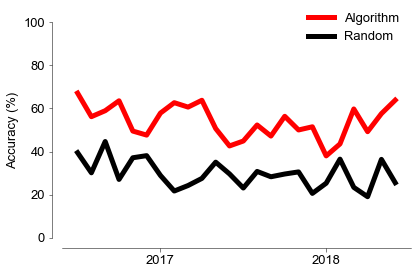

In [134]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.plot(range(24), burglary_final['perc'], lw=5, color='r', label='Algorithm')
plt.plot(range(24), burglary_final['random_perc'], lw=5, color='k', label='Random')
plt.ylim(0, 100)
plt.xticks([6, 18], ['2017', '2018'])
plt.legend(frameon=False, bbox_to_anchor=(1, 1.1))
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.savefig('figures/burglary_final.png')

In [127]:
robbery_final = robb.groupby('date').agg('sum')
robbery_final['perc'] = robbery_final['prediction']/robbery_final['observed']*100
robbery_final['random_perc'] = robbery_final['random_prediction']/robbery_final['observed']*100

In [128]:
burglary_final['prediction'].sum()/burglary_final['observed'].sum()

0.5385060799073538

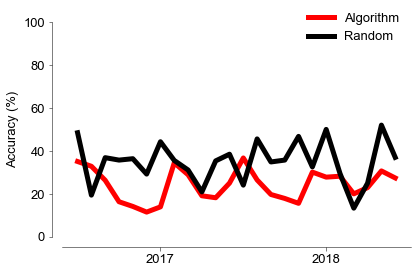

In [133]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.plot(range(24), robbery_final['perc'], lw=5, color='r', label='Algorithm')
plt.plot(range(24), robbery_final['random_perc'], lw=5, color='k', label='Random')
plt.ylim(0, 100)
plt.xticks([6, 18], ['2017', '2018'])
plt.tight_layout()
plt.legend(frameon=False, bbox_to_anchor=(1, 1.1))
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.savefig('figures/robbery_final.png')

In [ ]:
historical = [184652, 162908, 154809, 147069, 142093, 135475, 128682, 121009, 117956, 106730, 105115, 106669, 111147, 111335, 106722, 105453, 101716, 96658, 95883, 95606]

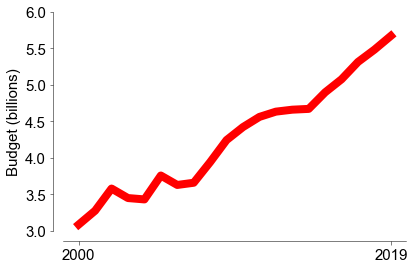

In [156]:
budget = [5668823,
5480432,
5312163,
5075081,
4896335,
4669342,
4658350,
4631506,
4559496,
4420306,
4242508,
3940064,
3657778,
3627798,
3756724,
3429797,
3448353,
3578458,
3275052,
3085518]

fig, ax = plt.subplots(figsize=(6, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.plot(range(len(budget)), [x/1000000 for x in list(reversed(budget))], lw=8, color='r')
plt.ylim(3, 6)
plt.xticks([0, 19], [2000, 2019])
plt.tight_layout()
plt.ylabel('Budget (billions)')
plt.tight_layout()
plt.savefig('figures/nypd_budget.png')

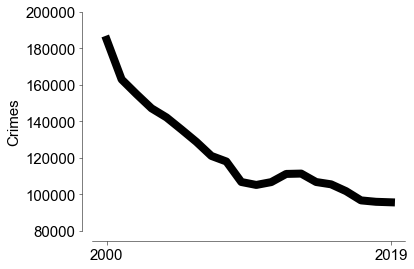

In [155]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.plot(range(len(budget)), historical, lw=8, color='k')
plt.ylim(80000, 200000)
plt.xticks([0, 19], [2000, 2019])
plt.tight_layout()
plt.ylabel('Crimes')
plt.tight_layout()
plt.savefig('figures/nypd_crime_rates.png')

In [ ]:
1999	2,700,300	202,545	(50,477)	(7,217)	2,845,151
1998	2,449,847	157,131	(71)	(11,684)	2,595,223
1997	2,303,167	153,443	(43)	(3,524)	2,453,043
1996	2,206,591	119,403	(80)	(846)	2,325,068
1995	1,923,207	116,788	(14)	(1,333)	2,038,648
1994	1,740,775	100,189	(23)	(2,301)	1,838,639
1993	1,699,607	103,534	(33)	(4,591)	1,798,517
1992	1,608,152	84,169	(41)	(4,252)	1,688,028
1991	1,551,994	84,881	(39)	(2,045)	1,634,790
1990	1,536,182	86,163	(30)	(633)	1,621,682
1989	1,433,321	81,208	(33)	(1,413)	1,513,082
1988	1,359,875	77,840	(13)	(967)	1,436,734
1987	1,258,614	67,698	(83)	(766)	1,325,463
1986	1,128,141	62,367	(227)	(1,095)	1,189,186
1985	1,030,076	62,421	(182)	(114)	1,092,200
1984	908,353	53,972	(189)	(507)	961,629
1983	819,350	45,673	(182)	(523)	864,317
1982	756,244	43,333	(133)	(334)	799,111
1981	680,777	38,311	(4,694)	(342)	714,051
1980	678,425	36,033	(11,958)	1,674	704,175